- [Data](#Data)
- [Model](#Model)

# Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from os.path import join
from os import listdir
import torch
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


# Utils

In [2]:
measure2index={"x-coordinate":0,"y-coordinate":1,"timestamp":2, "button_status":3,"pressure":4, "tilt":5,"elevation":6}
index2measure=list(measure2index.keys())

task2index={"spiral":0,"l":1,"le":2 ,"les":3,"lektorka" :4,"porovnat":5,"nepopadnout":6, "tram":7}
index2task=list(task2index.keys())

In [3]:
index2measure

['x-coordinate',
 'y-coordinate',
 'timestamp',
 'button_status',
 'pressure',
 'tilt',
 'elevation']

In [4]:
index2task

['spiral', 'l', 'le', 'les', 'lektorka', 'porovnat', 'nepopadnout', 'tram']

# Data
## Loading

In [5]:
data_path=join("..","PaHaW","PaHaW_public")#/00026/00026__1_1.svc"
folder_path=listdir(data_path)
folder_path.sort()

In [6]:
meta_path=join("..","PaHaW","corpus_PaHaW.csv")
meta_data=[]
with open(meta_path) as file:
    for line in file.readlines():
        meta_data.append(line.split(";"))
meta_data.pop(0)
meta_data=np.asarray(meta_data)
labels=[1 if i =="ON" else 0 for i in meta_data[:,4]]


In [7]:
"""a priori unnecessary for binary classif
target=[[0,1] if i ==1 else [1,0] for i in labels]"""

In [8]:
task_path=listdir(join(data_path,folder_path[46]))
task_path.sort()

Subjects 46 (control),
60 (PD) and
66 (control) didn't perform the spiral !


In [9]:
raw=[]
for folder in folder_path:
    subject=[]
    task_path=listdir(join(data_path,folder))
    task_path.sort()
    if len(task_path)!=8:#subject didn't perform the spiral
        subject.append([])#add an empty array so that all tasks are on the same column number
    for task in task_path:
        measures=[]
        path=join(data_path,folder,task)
        with open(path) as file:
            for line in file.readlines():
                measures.append(line.split())
            measures.pop(0)
        subject.append(measures)
    raw.append(subject)

In [10]:
print("(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)")
print(len(raw),len(raw[0]),len(raw[0][0]),len(raw[0][0][0]))

(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)
75 8 1772 7


The task sequence is in average **2286** &rarr; task duration is in average 11.4s

In [11]:
somme=0
for subject in raw:
    for task in subject:
        if len(task)!=0:#we don't take into account the 3 spirals not performed by subjects 46, 60 and 66
            somme+=len(task)
print("moyenne longueur",somme/(75*8-3))#-3 because 3 subjects didn't perform 1 task

moyenne longueur 2285.7939698492464


## Exploration

spiral
Subject n° 46 didn't perform spiral task
l
le
les
lektorka
porovnat
nepopadnout
tram


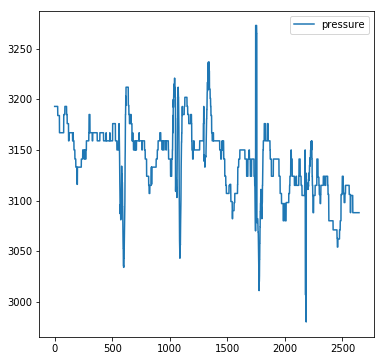

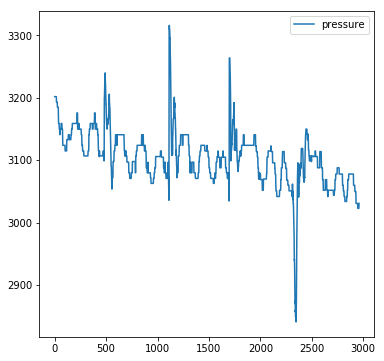

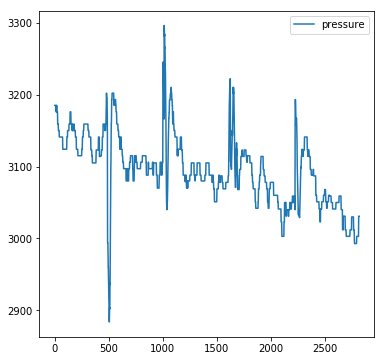

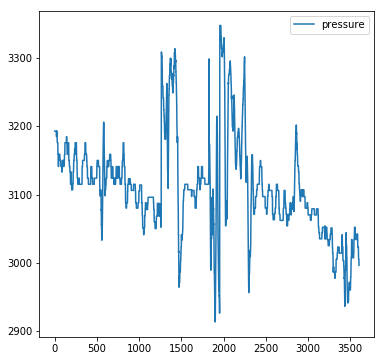

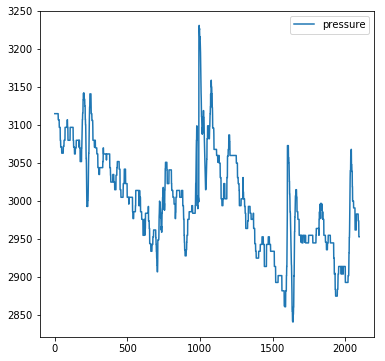

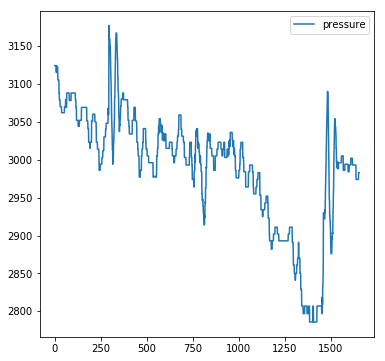

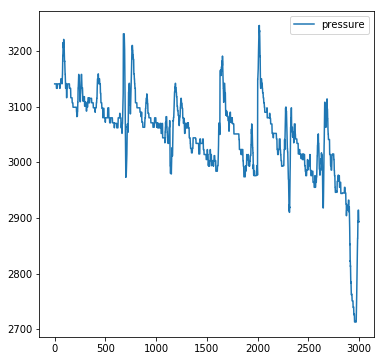

In [12]:
%matplotlib inline
subject_index=46
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure(figsize=(6,6))
        for i in [4]:
            plt.plot(task[:,i],label=index2measure[i])
            plt.legend()
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))
    

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


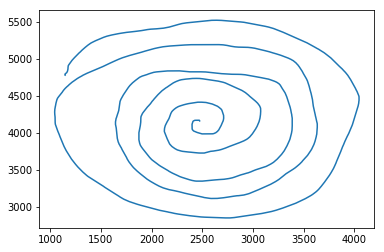

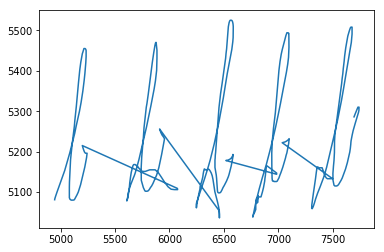

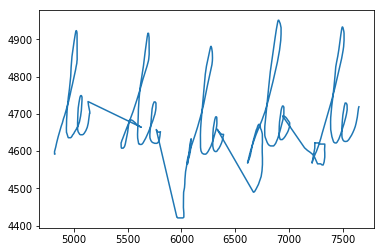

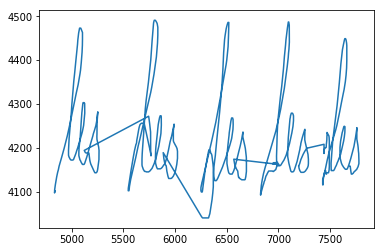

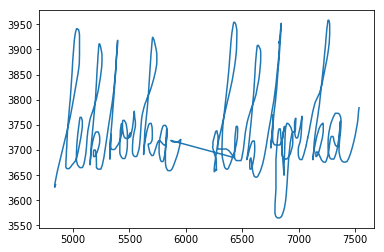

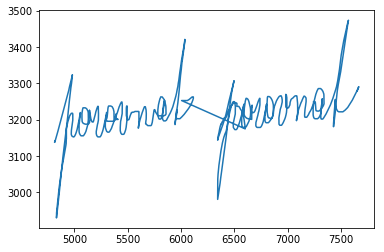

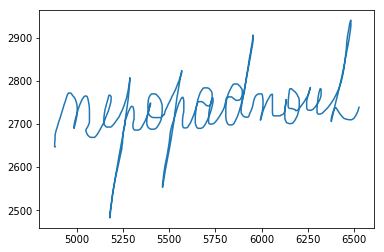

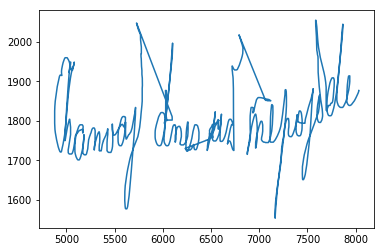

In [14]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

## Preprocessing
### Scaling
Looks similar to standardize &rarr; looks a bit distorted unlike normalize

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/ut

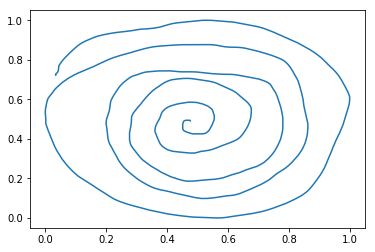

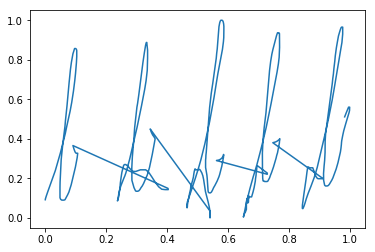

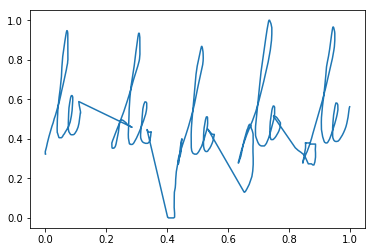

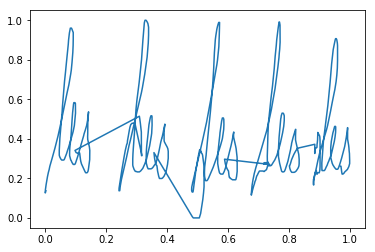

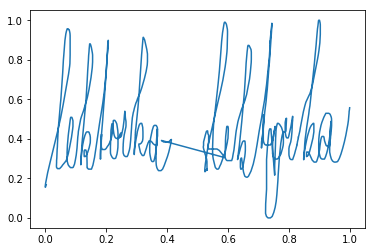

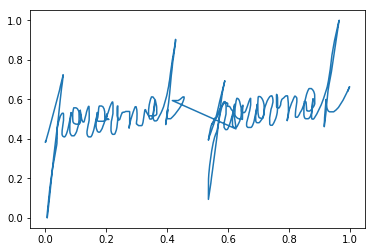

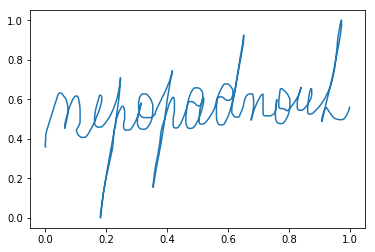

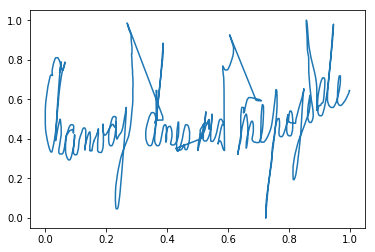

In [16]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
scaler = MinMaxScaler()
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=scaler.fit_transform(np.asarray(raw[subject_index][j],dtype=int))
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

### Standardize
I think it distorts a little bit the data, unlike normalizing

0
spiral
l
le
les
lektorka
porovnat


/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

nepopadnout
tram


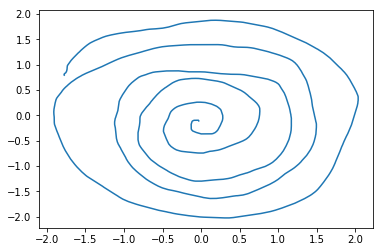

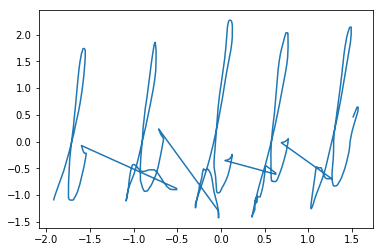

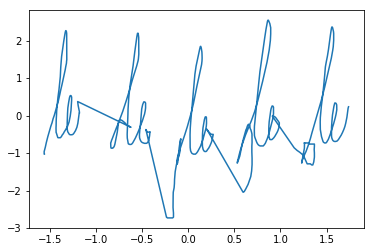

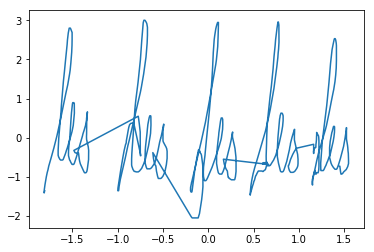

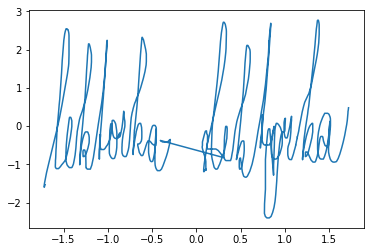

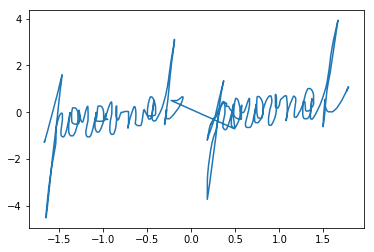

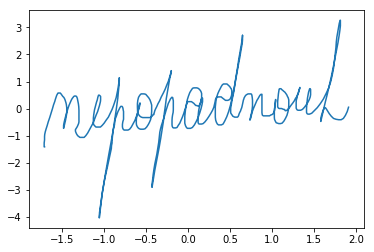

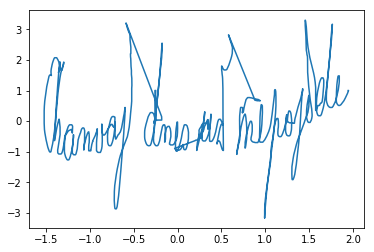

In [13]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=scale(np.asarray(raw[subject_index][j],dtype=int),axis=0)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

### Normalization
Normalize along axis 0 in order to normalize all the measures (and not all tasks independently)

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


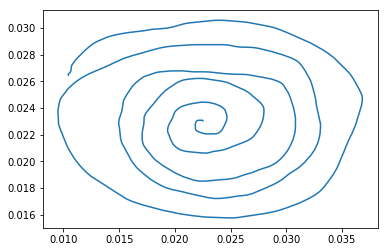

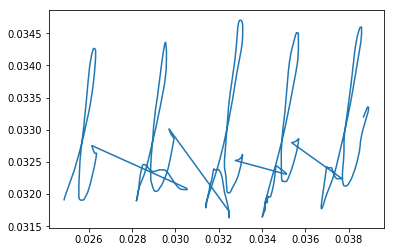

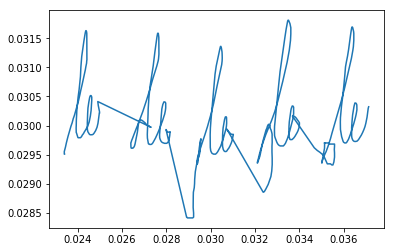

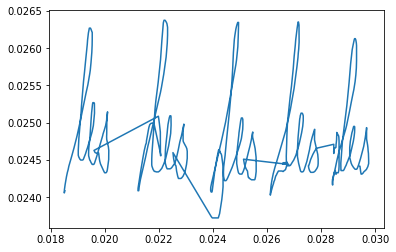

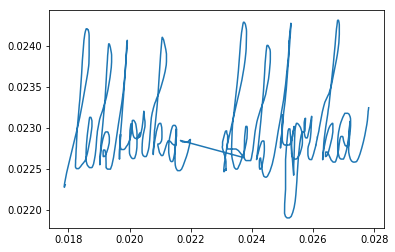

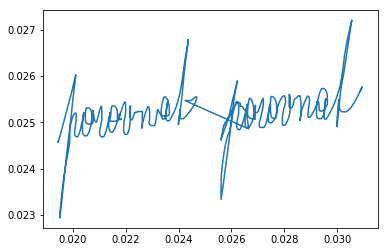

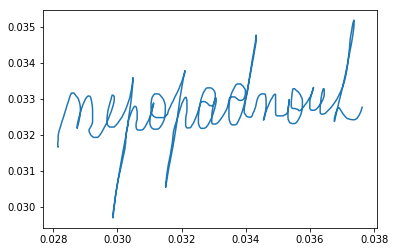

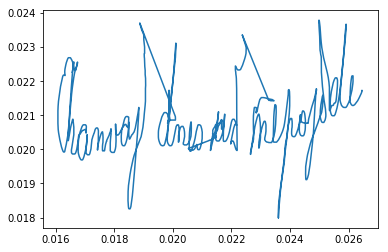

In [23]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in racnge(8):
    print(index2task[j])
    task=normalize(np.asarray(raw[subject_index][j],dtype=int),axis=0)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

## Spirals

In [83]:
spirals=[raw[i][0]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]#discard the subjects that didn't perform spiral

In [141]:
spiral_targets= [labels[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]
#for multi class #[target[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]
#discard the subjects that didn't perform spiral

In [142]:
len(spirals),len(spiral_targets)

(72, 72)

In [86]:
display=False
for i,spiral in enumerate(spirals):
    spirals[i]=normalize(np.asarray(spiral,dtype=int),axis=0)
    if display:        
        plt.figure()
        plt.plot(spirals[i][:,1],spirals[i][:,0])

In [107]:
#spiral_targets=np.asarray(spiral_targets,dtype=int)

### Data split
In order to provide for a meaningful comparison with works from Drotar et al. and Moetesum et al. we will evaluate our results using a 10-fold cross validation

In [88]:
"""split_ratio=len(spiral_targets)-len(spiral_targets)//10,len(spiral_targets)//10

split_ratio

split_ratio[0]+split_ratio[1]==len(spiral_targets)

np.random.seed(1)
random_index=np.random.randint(0,high=len(spiral_targets),size=(len(spiral_targets)))

random_index

train_set=[spirals[i] for i in random_index[0:split_ratio[0]]]
test_set=[spirals[i] for i in random_index[split_ratio[0]:split_ratio[0]+split_ratio[1]]]

train_targets=[spiral_targets[i] for i in random_index[0:split_ratio[0]+1]]
test_targets=[spiral_targets[i] for i in random_index[split_ratio[0]:split_ratio[0]+split_ratio[1]+1]]

sum([1 if i[1]==1 else 0 for i in spiral_targets])

sum([1 if i[1]==1 else 0 for i in train_targets]),sum([1 if i[1]==1 else 0 for i in test_targets])

25/65,4/7

len(train_targets),len(test_targets)"""

'split_ratio=len(spiral_targets)-len(spiral_targets)//10,len(spiral_targets)//10\n\nsplit_ratio\n\nsplit_ratio[0]+split_ratio[1]==len(spiral_targets)\n\nnp.random.seed(1)\nrandom_index=np.random.randint(0,high=len(spiral_targets),size=(len(spiral_targets)))\n\nrandom_index\n\ntrain_set=[spirals[i] for i in random_index[0:split_ratio[0]]]\ntest_set=[spirals[i] for i in random_index[split_ratio[0]:split_ratio[0]+split_ratio[1]]]\n\ntrain_targets=[spiral_targets[i] for i in random_index[0:split_ratio[0]+1]]\ntest_targets=[spiral_targets[i] for i in random_index[split_ratio[0]:split_ratio[0]+split_ratio[1]+1]]\n\nsum([1 if i[1]==1 else 0 for i in spiral_targets])\n\nsum([1 if i[1]==1 else 0 for i in train_targets]),sum([1 if i[1]==1 else 0 for i in test_targets])\n\n25/65,4/7\n\nlen(train_targets),len(test_targets)'

In [ ]:
"""first_train_index=0
first_test_index=split_ratio[1]

spiral_targets(random_index[first_train_index]:random_index[first_test_index])"""

# Model
- [**Pytorch LSTM doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [**Pytorch Linear doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)

## Definition

In [113]:
class Model(torch.nn.Module):
    """
    Args:
        #Vanilla LSTM
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
        
        #our model
        batch_size : default : 1
        output_size : default : 2
    """
    def __init__(self, input_size, hidden_size,num_layers=1, bias=True,batch_first=False,
                 dropout=0,bidirectional=False, batch_size=1, output_size=2):
        super(Model, self).__init__()
        #Vanilla LSTM
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias=bias
        self.batch_first=batch_first
        self.dropout=dropout
        self.bidirectional=bidirectional
        #our model
        self.batch_size = batch_size
        self.output_size = output_size

        # Define the LSTM layer
        self.encoder = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers,self.bias,self.batch_first,
                            self.dropout,self.bidirectional)

        # Define the decoder layer
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def init_hidden(self):
        """h_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial hidden state for each element in the batch. 
        If the RNN is bidirectional, num_directions should be 2, else it should be 1.

        c_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial cell state for each element in the batch.
        """
        num_directions=1
        if self.bidirectional:
            num_directions=2
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of encoder_out: (seq_len, batch, num_directions * hidden_size)
        # shape of self.hidden: (h_n, c_n), where hidden state h_n and cell state c_n both 
        # have shape (num_layers * num_directions, batch, hidden_size).
        encoder_out, self.hidden = self.encoder(input)#input.view(len(input), self.batch_size, -1))# probably (=) unsqueeze(1)
        
        
        if self.bidirectional:
            #sums the outputs : direction left-right and direction right-left
            # encoder_out shape should now be (seq_len, batch,hidden_size)
            encoder_out = encoder_out[: ,: ,: self.hidden_size] + encoder_out[: , :, self.hidden_size: ]
        
        # Only take the output from the final timestep
        # Can pass on the entirety of encoder_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(encoder_out[-1].view(self.batch_size, -1))
        y_pred = self.sigmoid(y_pred)
        return y_pred.view(-1)


## Hyperparameters / Init

In [158]:
input_size=7#==len(index2measure)
hidden_size=100
num_layers=2
bias=True
batch_first=False#we should unsqueeze(1) to add a batch dimension
dropout=0.2
bidirectional=True
batch_size=1
output_size=1#binary classif : 1 means PD, 0 means control
learning_rate = 1e-4



In [159]:
model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
model.init_hidden()
model=model.to(device)

In [160]:
loss_fn=torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training
### step
[**Pytorch Binary Cross Entropy loss (BCELoss) doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)

In [162]:
def step(input, target, model, optimizer, loss_fn, batch_size):
    # Zero gradients
    optimizer.zero_grad()    
    # Set device options
    input=input.to(device)
    target=target.to(device)
        
    #forward pass
    output=model(input)
    
    # Compute loss
    loss = loss_fn(output, target)
    # Perform backpropagation
    loss.backward()
    # Adjust model weights
    optimizer.step()
    
    return loss.item()

In [153]:
#numpy to tensor
subject=torch.Tensor(spirals[0]).unsqueeze(1)#add batch dimension
target=torch.Tensor([spiral_targets[0]])

In [161]:
%%time
step(subject,target, model, optimizer, loss_fn, batch_size)

CPU times: user 592 ms, sys: 36 ms, total: 628 ms
Wall time: 624 ms


tensor(0.7189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [155]:
losses=[]
for _ in range(500):

    losses.append(step(subject,target, model, optimizer, loss_fn, batch_size))

KeyboardInterrupt: 

In [156]:
[i.item() for i in losses]

[0.688905656337738,
 0.6863564252853394,
 0.6834222078323364,
 0.6814681887626648,
 0.6758445501327515,
 0.6766172051429749,
 0.6743464469909668,
 0.6724478602409363,
 0.6675876975059509,
 0.6656786203384399,
 0.6628716588020325,
 0.664557933807373,
 0.6583089232444763,
 0.6567445993423462,
 0.6543941497802734,
 0.6500533819198608,
 0.6495687365531921,
 0.6467212438583374,
 0.6430140733718872,
 0.6438432335853577,
 0.6373472213745117,
 0.6365101337432861,
 0.6310526132583618,
 0.6309459805488586,
 0.6256378889083862,
 0.6241018176078796,
 0.6227798461914062,
 0.6138854622840881,
 0.613278865814209,
 0.6145687103271484,
 0.6076698899269104,
 0.6058535575866699,
 0.6025643944740295,
 0.598394513130188,
 0.5934772491455078,
 0.5875347256660461,
 0.5900241732597351,
 0.58524090051651,
 0.5777853727340698,
 0.5753126740455627,
 0.5712479948997498,
 0.5691080689430237,
 0.5602740049362183,
 0.555698812007904,
 0.5517116189002991,
 0.5486518144607544,
 0.5429437160491943,
 0.5389648675918579,